The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3
!pip install -U mxnet-cu112==1.9.1


# Learning Rate Scheduling
:label:`sec_scheduler`

So far we primarily focused on optimization *algorithms* for how to update the weight vectors rather than on the *rate* at which they are being updated. Nonetheless, adjusting the learning rate is often just as important as the actual algorithm. There are a number of aspects to consider:

* Most obviously the *magnitude* of the learning rate matters. If it is too large, optimization diverges, if it is too small, it takes too long to train or we end up with a suboptimal result. We saw previously that the condition number of the problem matters (see e.g., :numref:`sec_momentum` for details). Intuitively it is the ratio of the amount of change in the least sensitive direction vs. the most sensitive one.
* Secondly, the rate of decay is just as important. If the learning rate remains large we may simply end up bouncing around the minimum and thus not reach optimality. :numref:`sec_minibatch_sgd` discussed this in some detail and we analyzed performance guarantees in :numref:`sec_sgd`. In short, we want the rate to decay, but probably more slowly than $\mathcal{O}(t^{-\frac{1}{2}})$ which would be a good choice for convex problems.
* Another aspect that is equally important is *initialization*. This pertains both to how the parameters are set initially (review :numref:`sec_numerical_stability` for details) and also how they evolve initially. This goes under the moniker of *warmup*, i.e., how rapidly we start moving towards the solution initially. Large steps in the beginning might not be beneficial, in particular since the initial set of parameters is random. The initial update directions might be quite meaningless, too.
* Lastly, there are a number of optimization variants that perform cyclical learning rate adjustment. This is beyond the scope of the current chapter. We recommend the reader to review details in :citet:`Izmailov.Podoprikhin.Garipov.ea.2018`, e.g., how to obtain better solutions by averaging over an entire *path* of parameters.

Given the fact that there is a lot of detail needed to manage learning rates, most deep learning frameworks have tools to deal with this automatically. In the current chapter we will review the effects that different schedules have on accuracy and also show how this can be managed efficiently via a *learning rate scheduler*.

## Toy Problem

We begin with a toy problem that is cheap enough to compute easily, yet sufficiently nontrivial to illustrate some of the key aspects. For that we pick a slightly modernized version of LeNet (`relu` instead of `sigmoid` activation, MaxPooling rather than AveragePooling), as applied to Fashion-MNIST. Moreover, we hybridize the network for performance. Since most of the code is standard we just introduce the basics without further detailed discussion. See :numref:`chap_cnn` for a refresher as needed.


In [1]:
%matplotlib inline
from mxnet import autograd, gluon, init, lr_scheduler, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

net = nn.HybridSequential()
net.add(nn.Conv2D(channels=6, kernel_size=5, padding=2, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Dense(120, activation='relu'),
        nn.Dense(84, activation='relu'),
        nn.Dense(10))
net.hybridize()
loss = gluon.loss.SoftmaxCrossEntropyLoss()
device = d2l.try_gpu()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# The code is almost identical to `d2l.train_ch6` defined in the
# lenet section of chapter convolutional neural networks
def train(net, train_iter, test_iter, num_epochs, loss, trainer, device):
    net.initialize(force_reinit=True, ctx=device, init=init.Xavier())
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            X, y = X.as_in_ctx(device), y.as_in_ctx(device)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y)
            l.backward()
            trainer.step(X.shape[0])
            metric.add(l.sum(), d2l.accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

[22:48:45] ../src/storage/storage.cc:196: Using Pooled (Naive) StorageManager for CPU


Let's have a look at what happens if we invoke this algorithm with default settings, such as a learning rate of $0.3$ and train for $30$ iterations. Note how the training accuracy keeps on increasing while progress in terms of test accuracy stalls beyond a point. The gap between both curves indicates overfitting.


train loss 0.160, train acc 0.939, test acc 0.884


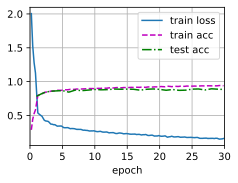

In [2]:
lr, num_epochs = 0.3, 30
net.initialize(force_reinit=True, ctx=device, init=init.Xavier())
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

## Schedulers

One way of adjusting the learning rate is to set it explicitly at each step. This is conveniently achieved by the `set_learning_rate` method. We could adjust it downward after every epoch (or even after every minibatch), e.g., in a dynamic manner in response to how optimization is progressing.


In [3]:
trainer.set_learning_rate(0.1)
print(f'learning rate is now {trainer.learning_rate:.2f}')

learning rate is now 0.10


More generally we want to define a scheduler. When invoked with the number of updates it returns the appropriate value of the learning rate. Let's define a simple one that sets the learning rate to $\eta = \eta_0 (t + 1)^{-\frac{1}{2}}$.


In [4]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)

Let's plot its behavior over a range of values.


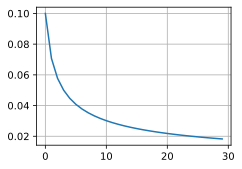

In [5]:
scheduler = SquareRootScheduler(lr=0.1)
d2l.plot(np.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

Now let's see how this plays out for training on Fashion-MNIST. We simply provide the scheduler as an additional argument to the training algorithm.


train loss 0.523, train acc 0.810, test acc 0.815


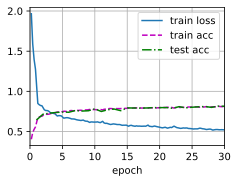

In [6]:
trainer = gluon.Trainer(net.collect_params(), 'sgd',
                        {'lr_scheduler': scheduler})
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

This worked quite a bit better than previously. Two things stand out: the curve was rather more smooth than previously. Secondly, there was less overfitting. Unfortunately it is not a well-resolved question as to why certain strategies lead to less overfitting in *theory*. There is some argument that a smaller stepsize will lead to parameters that are closer to zero and thus simpler. However, this does not explain the phenomenon entirely since we do not really stop early but simply reduce the learning rate gently.

## Policies

While we cannot possibly cover the entire variety of learning rate schedulers, we attempt to give a brief overview of popular policies below. Common choices are polynomial decay and piecewise constant schedules. Beyond that, cosine learning rate schedules have been found to work well empirically on some problems. Lastly, on some problems it is beneficial to warm up the optimizer prior to using large learning rates.

### Factor Scheduler

One alternative to a polynomial decay would be a multiplicative one, that is $\eta_{t+1} \leftarrow \eta_t \cdot \alpha$ for $\alpha \in (0, 1)$. To prevent the learning rate from decaying beyond a reasonable lower bound the update equation is often modified to $\eta_{t+1} \leftarrow \mathop{\mathrm{max}}(\eta_{\mathrm{min}}, \eta_t \cdot \alpha)$.


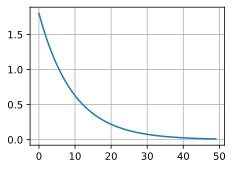

In [7]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
d2l.plot(np.arange(50), [scheduler(t) for t in range(50)])

This can also be accomplished by a built-in scheduler in MXNet via the `lr_scheduler.FactorScheduler` object. It takes a few more parameters, such as warmup period, warmup mode (linear or constant), the maximum number of desired updates, etc.; Going forward we will use the built-in schedulers as appropriate and only explain their functionality here. As illustrated, it is fairly straightforward to build your own scheduler if needed.

### Multi Factor Scheduler

A common strategy for training deep networks is to keep the learning rate piecewise constant and to decrease it by a given amount every so often. That is, given a set of times when to decrease the rate, such as $s = \{5, 10, 20\}$ decrease $\eta_{t+1} \leftarrow \eta_t \cdot \alpha$ whenever $t \in s$. Assuming that the values are halved at each step we can implement this as follows.


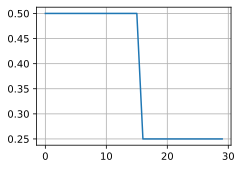

In [8]:
scheduler = lr_scheduler.MultiFactorScheduler(step=[15, 30], factor=0.5,
                                              base_lr=0.5)
d2l.plot(np.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

The intuition behind this piecewise constant learning rate schedule is that one lets optimization proceed until a stationary point has been reached in terms of the distribution of weight vectors. Then (and only then) do we decrease the rate such as to obtain a higher quality proxy to a good local minimum. The example below shows how this can produce ever slightly better solutions.


train loss 0.194, train acc 0.927, test acc 0.887


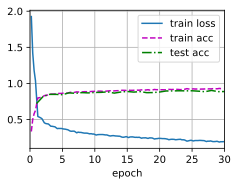

In [9]:
trainer = gluon.Trainer(net.collect_params(), 'sgd',
                        {'lr_scheduler': scheduler})
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

### Cosine Scheduler

A rather perplexing heuristic was proposed by :citet:`Loshchilov.Hutter.2016`. It relies on the observation that we might not want to decrease the learning rate too drastically in the beginning and moreover, that we might want to "refine" the solution in the end using a very small learning rate. This results in a cosine-like schedule with the following functional form for learning rates in the range $t \in [0, T]$.

$$\eta_t = \eta_T + \frac{\eta_0 - \eta_T}{2} \left(1 + \cos(\pi t/T)\right)$$


Here $\eta_0$ is the initial learning rate, $\eta_T$ is the target rate at time $T$. Furthermore, for $t > T$ we simply pin the value to $\eta_T$ without increasing it again. In the following example, we set the max update step $T = 20$.


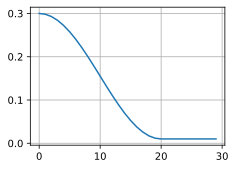

In [10]:
scheduler = lr_scheduler.CosineScheduler(max_update=20, base_lr=0.3,
                                         final_lr=0.01)
d2l.plot(np.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

In the context of computer vision this schedule *can* lead to improved results. Note, though, that such improvements are not guaranteed (as can be seen below).


train loss 0.343, train acc 0.878, test acc 0.859


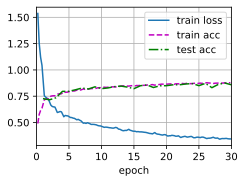

In [11]:
trainer = gluon.Trainer(net.collect_params(), 'sgd',
                        {'lr_scheduler': scheduler})
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

### Warmup

In some cases initializing the parameters is not sufficient to guarantee a good solution. This is particularly a problem for some advanced network designs that may lead to unstable optimization problems. We could address this by choosing a sufficiently small learning rate to prevent divergence in the beginning. Unfortunately this means that progress is slow. Conversely, a large learning rate initially leads to divergence.

A rather simple fix for this dilemma is to use a warmup period during which the learning rate *increases* to its initial maximum and to cool down the rate until the end of the optimization process. For simplicity one typically uses a linear increase for this purpose. This leads to a schedule of the form indicated below.


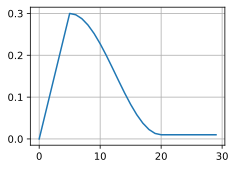

In [12]:
scheduler = lr_scheduler.CosineScheduler(20, warmup_steps=5, base_lr=0.3,
                                         final_lr=0.01)
d2l.plot(np.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

Note that the network converges better initially (in particular observe the performance during the first 5 epochs).


train loss 0.348, train acc 0.874, test acc 0.871


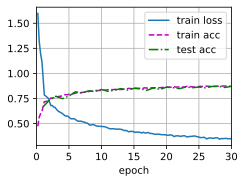

In [13]:
trainer = gluon.Trainer(net.collect_params(), 'sgd',
                        {'lr_scheduler': scheduler})
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

Warmup can be applied to any scheduler (not just cosine). For a more detailed discussion of learning rate schedules and many more experiments see also :cite:`Gotmare.Keskar.Xiong.ea.2018`. In particular they find that a warmup phase limits the amount of divergence of parameters in very deep networks. This makes intuitively sense since we would expect significant divergence due to random initialization in those parts of the network that take the most time to make progress in the beginning.

## Summary

* Decreasing the learning rate during training can lead to improved accuracy and (most perplexingly) reduced overfitting of the model.
* A piecewise decrease of the learning rate whenever progress has plateaued is effective in practice. Essentially this ensures that we converge efficiently to a suitable solution and only then reduce the inherent variance of the parameters by reducing the learning rate.
* Cosine schedulers are popular for some computer vision problems. See e.g., [GluonCV](http://gluon-cv.mxnet.io) for details of such a scheduler.
* A warmup period before optimization can prevent divergence.
* Optimization serves multiple purposes in deep learning. Besides minimizing the training objective, different choices of optimization algorithms and learning rate scheduling can lead to rather different amounts of generalization and overfitting on the test set (for the same amount of training error).

## Exercises

1. Experiment with the optimization behavior for a given fixed learning rate. What is the best model you can obtain this way?
1. How does convergence change if you change the exponent of the decrease in the learning rate? Use `PolyScheduler` for your convenience in the experiments.
1. Apply the cosine scheduler to large computer vision problems, e.g., training ImageNet. How does it affect performance relative to other schedulers?
1. How long should warmup last?
1. Can you connect optimization and sampling? Start by using results from :citet:`Welling.Teh.2011` on Stochastic Gradient Langevin Dynamics.


[Discussions](https://discuss.d2l.ai/t/359)
